# P5 - Vehicle Detection and Tracking

## Section one: make a classifier
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

### Plot image samples

In [875]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from scipy.ndimage.measurements import label
import matplotlib.gridspec as gs

%matplotlib inline

In [876]:
sample_vehicle = mpimg.imread('../datasets/GTI/vehicles/GTI_Far/image0002.png')
sample_non_vehicle = mpimg.imread('../datasets/GTI/non-vehicles/GTI/image5.png')

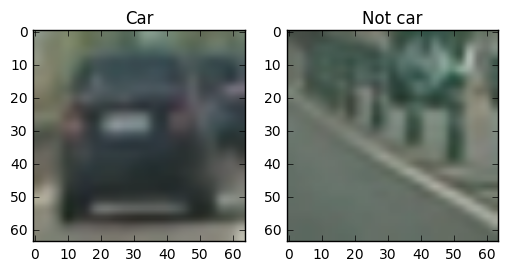

In [985]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(sample_vehicle)
ax1.set_title("Car")

ax2.imshow(sample_non_vehicle)
ax2.set_title("Not car")


## Visualizing Features

In [878]:
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler


### Hog Feature Extraction

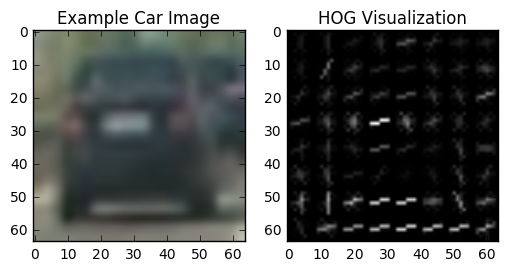

In [879]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  feature_vector=feature_vec, visualise=vis, transform_sqrt=True)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                       cells_per_block=(cell_per_block, cell_per_block), 
                       feature_vector=feature_vec, visualise=vis, transform_sqrt=True)
        return features

# Read in the image
image = sample_vehicle
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                                       pix_per_cell, cell_per_block, 
                                       vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

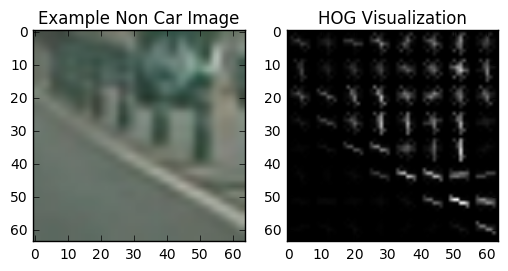

In [880]:
# Read in the image
image = sample_non_vehicle
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                                       pix_per_cell, cell_per_block, 
                                       vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Non Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

### Spatial Binning of Color

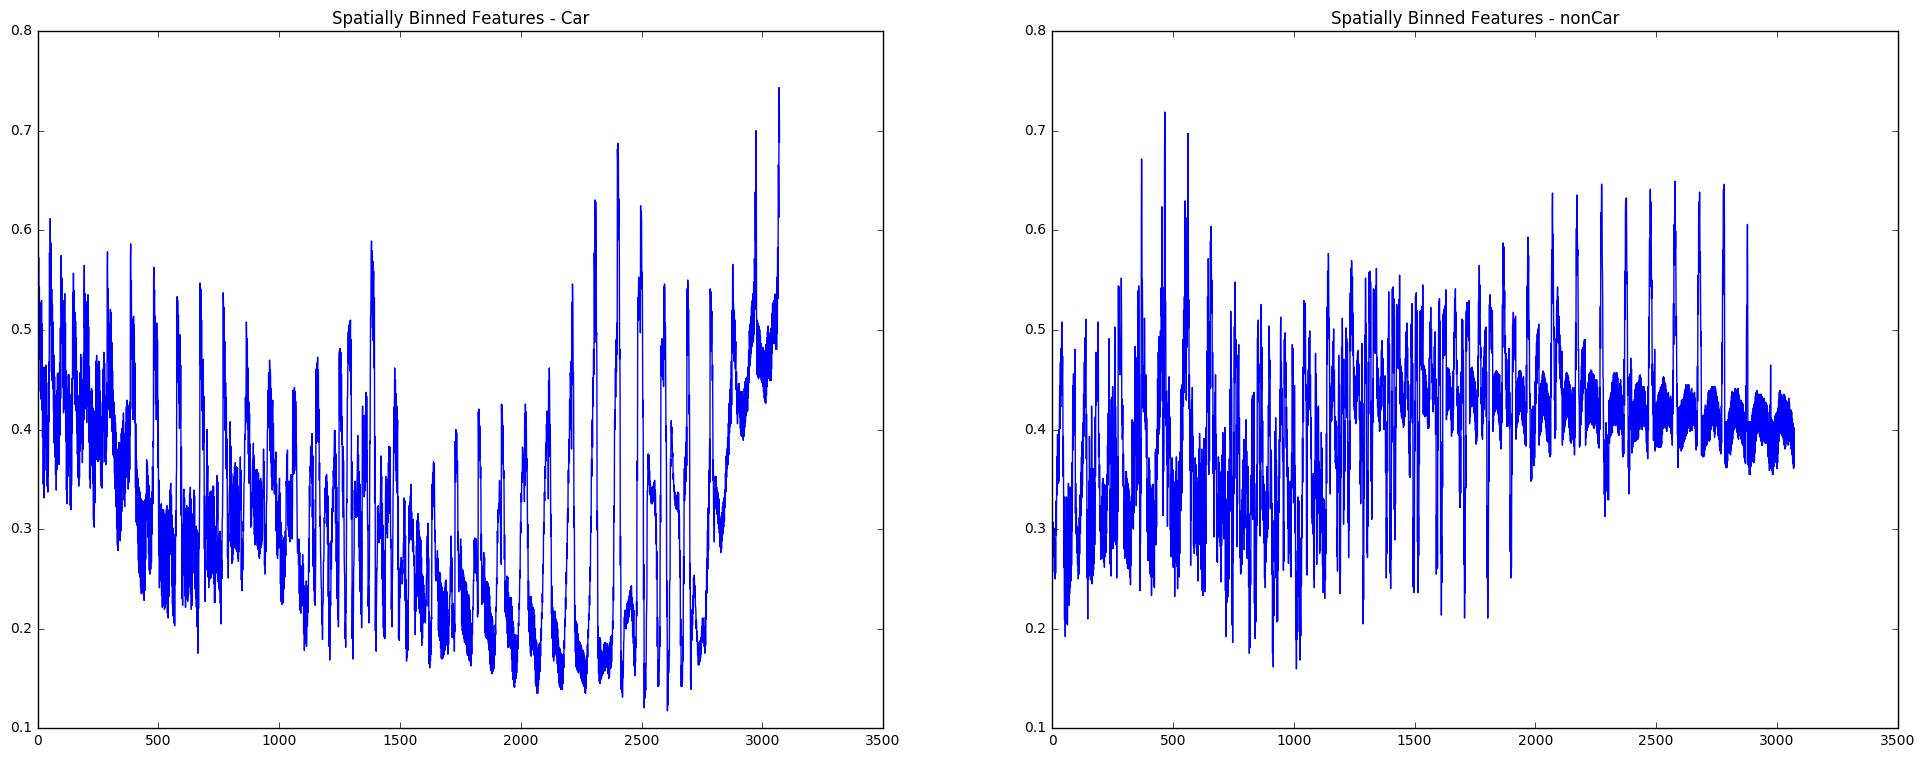

In [989]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        color_method = getattr(cv2, 'COLOR_RGB2'+ color_space)
        img = cv2.cvtColor(img, color_method)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Get feature vector
feature_vec_car = bin_spatial(sample_vehicle, color_space='RGB', size=(32, 32))
feature_vec_noncar = bin_spatial(sample_non_vehicle, color_space='RGB', size=(32, 32))

# Plot features
fig = plt.figure(figsize=(24,9))
plt.subplot(121)
plt.plot(feature_vec_car)
plt.title('Spatially Binned Features - Car')
plt.subplot(122)
plt.plot(feature_vec_noncar)
plt.title('Spatially Binned Features - nonCar')

### Color Histograms

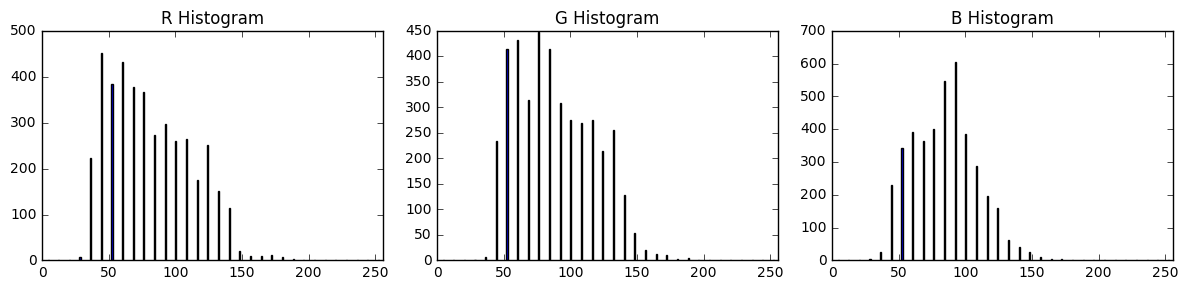

In [883]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:, : ,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:, : ,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:, : ,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers=(bin_edges[1:] + bin_edges[:-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate([rhist[0], ghist[0], bhist[0]])
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

image = sample_vehicle*255
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')


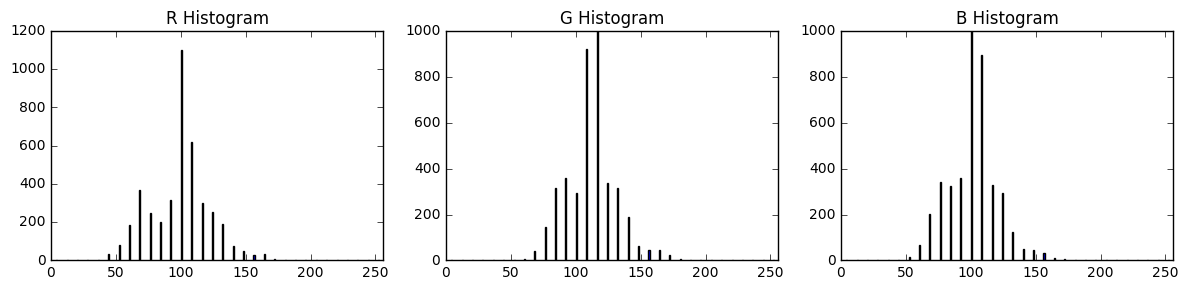

In [884]:
image = sample_non_vehicle*255
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

In [885]:
# Read in our vehicles and non-vehicles
images = glob.glob('*.jpeg')
cars = []
notcars = []

for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        

### Combine and Normalize Features

In [886]:
cars = glob.glob('../datasets/GTI/vehicles/*/*.png')
notcars = glob.glob('../datasets/GTI/non-vehicles/*/*.png')

In [887]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    img = img*255
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img_path in imgs:
        # Read in each one by one
        img = mpimg.imread(img_path)#*255 # np.asarray(Image.open(img_path))
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            color_method = getattr(cv2, 'COLOR_RGB2' + cspace)
            img = cv2.cvtColor(img, color_method)
        # Apply bin_spatial() to get spatial color features
        spatial_color_feat = bin_spatial(img, spatial_size)
        # Apply color_hist() to get color histogram features
        hist_color_feat = color_hist(img, hist_bins, hist_range)
        # Append the new feature vector to the features list
        feats = np.concatenate([spatial_color_feat, hist_color_feat]).astype(np.float64)
        features.append(feats)
    # Return list of feature vectors
    return features


In [888]:
# extract features
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))


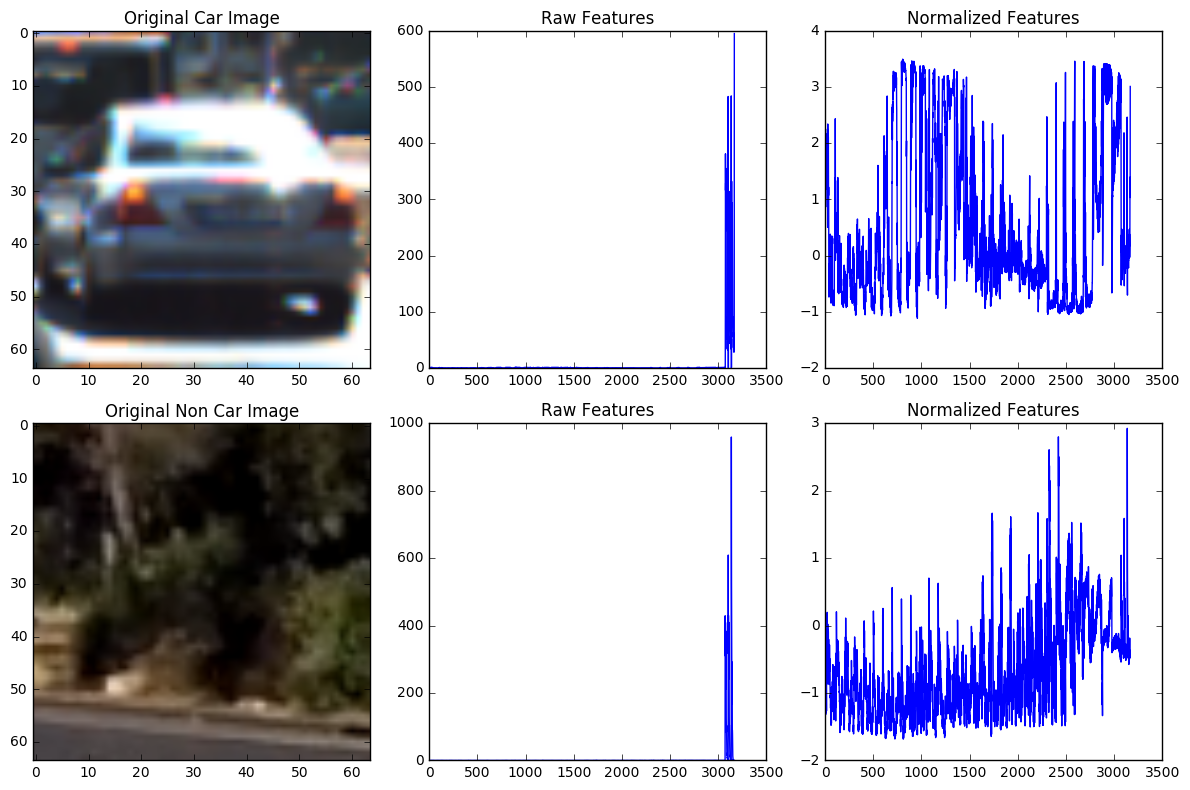

In [889]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# get an example and plot
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,8))
# plot car image features
plt.subplot(231)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Car Image')
plt.subplot(232)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(233)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
# plot not car image featurs
plt.subplot(234)
plt.imshow(mpimg.imread(notcars[notcar_ind]))
plt.title('Original Non Car Image')
plt.subplot(235)
plt.plot(X[notcar_ind + len(cars)])
plt.title('Raw Features')
plt.subplot(236)
plt.plot(scaled_X[notcar_ind + len(cars)])
plt.title('Normalized Features')

fig.tight_layout()


### Train a linear classifier

In [890]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from time import time

In [891]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [892]:
# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=42)


In [893]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t0=time()
svc.fit(X_train, y_train)
print(round(time() - t0, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t0 = time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
print(round(time() -t0, 5), 'Seconds to predict', n_predict,'labels with SVC')

20.79 Seconds to train SVC...
Test Accuracy of SVC =  0.9572
My SVC predicts:  [ 0.  0.  1.  1.  0.  1.  0.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  1.  0.  1.  0.  1.]
0.00114 Seconds to predict 10 labels with SVC


In [894]:
X.shape, X.mean(), X.std()

((18458, 3168), 4.1858903202681645, 48.296543298325865)

In [895]:
y.shape, y.mean(), y.std()

((18458,), 0.47632462888720339, 0.49943916226370483)

In [896]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            color_method = getattr(cv2, 'COLOR_RGB2' + cspace)
            feature_image = cv2.cvtColor(image, color_method)
        else: 
            feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 16
cell_per_block = 4
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t0=time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

print(round(time()-t0, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=42)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t0=time()
svc.fit(X_train, y_train)
print(round(time()-t0, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t0=time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
print(round(time()-t0, 5), 'Seconds to predict', n_predict,'labels with SVC')

34.18 Seconds to extract HOG features...
Using: 9 orientations 16 pixels per cell and 4 cells per block
Feature vector length: 432
2.35 Seconds to train SVC...
Test Accuracy of SVC =  0.9772
My SVC predicts:  [ 0.  0.  1.  1.  0.  1.  0.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  1.  0.  1.  0.  1.]
0.0011 Seconds to predict 10 labels with SVC


Combining HOG and color features:

In [897]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """ Function to extract features from a single image window.
        Similar to extract_features(), just for a single image rather than list of images
    """
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB', only to HOG
    feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        # convert to 0-255 before passing to color_hist function
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if color_space != 'RGB':
            color_method = getattr(cv2, 'COLOR_RGB2' + color_space)
            feature_image = cv2.cvtColor(img, color_method)            
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features).astype(np.float64)

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        img = mpimg.imread(file)
        img_features = single_img_features(img, color_space=color_space, spatial_size=spatial_size, 
                                           hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                           cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                           spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        features.append(img_features)
    # Return list of feature vectors
    return features


In [898]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' #'YCrCb' #RGB # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # 8 # HOG pixels per cell
cell_per_block = 4 # 4 # HOG cells per block
hog_channel = 'ALL' # 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # (16, 16) # Spatial binning dimensions
hist_bins = 32 # 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t0=time()
car_features = extract_features(cars, color_space=color_space, orient=orient, 
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
print(round(time()-t0, 2), 'Seconds to extract car features...')

t0=time()
notcar_features = extract_features(notcars, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
print(round(time()-t0, 2), 'Seconds to extract non-car features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=42)

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t0=time()
svc.fit(X_train, y_train)
print(round(time()-t0, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t0=time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
print(round(time()-t0, 5), 'Seconds to predict', n_predict,'labels with SVC')

21.09 Seconds to extract car features...
22.71 Seconds to extract non-car features...
7.76 Seconds to train SVC...
Test Accuracy of SVC =  0.9916
My SVC predicts:  [ 0.  0.  1.  1.  0.  1.  0.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  1.  0.  1.  0.  1.]
0.00118 Seconds to predict 10 labels with SVC


## Section 2: Implement a sliding window technique

* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Estimate a bounding box for vehicles detected.

In [899]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """ Draw a bounding box on the image"""
    
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [900]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                   xy_window=[(64, 64)], xy_overlap=(0.5, 0.5), debug=False):
    """ Define a function that takes an image, start and stop positions in both x and y, 
        window size (x and y dimensions), and overlap fraction (for both x and y)
        
        Improved version of slide_window:
        - establish a list of different windows sizes (accept multiple xy_windows)
        - restrict search to area of images the vehicles should appear (y_stop defaults to 350)
        - vehicles near the horizon will be smaller - pending (pending)
        
    """
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    # Initialize a list to append window positions to
    window_list = []

    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1

    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
                
    # Return the list of windows
    return window_list



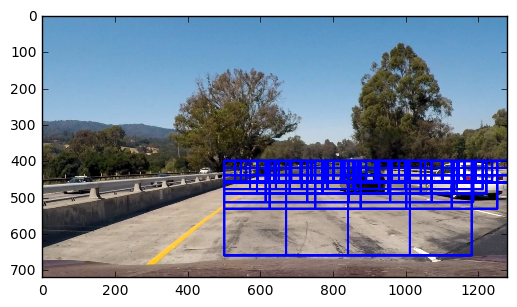

In [991]:
image = mpimg.imread('test_images/test1.jpg')
y_start_stop = [350, image.shape[0]]
xy_windows = (64,64)

all_windows = []
for region, window, in region_window:

    # Adjust these parameters
    y_start_stop = [region[1], region[0]]
    x_start_stop = [500, 1280]
    xy_window = window

    # get windows
    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=xy_window, xy_overlap=xy_overlap)

    all_windows.extend(windows)


window_img = draw_boxes(image, all_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img);

### Search and classify

In [902]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

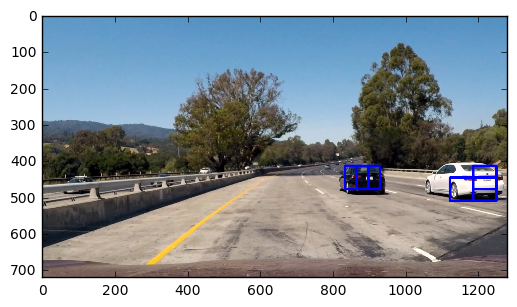

In [903]:
image = mpimg.imread('test_images/test1.jpg')
# image = mpimg.imread(cars[3])
draw_image = np.copy(image)

# Adjust these parameters
y_start_stop = [350, image.shape[0]]
xy_window = (64,64)
xy_overlap=(0.5, 0.5)

# get windows
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=xy_window, xy_overlap=xy_overlap)

# convert to 0-1 range for classification
image = image.astype(np.float32)/255

# search for windows with possible predictions
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img);

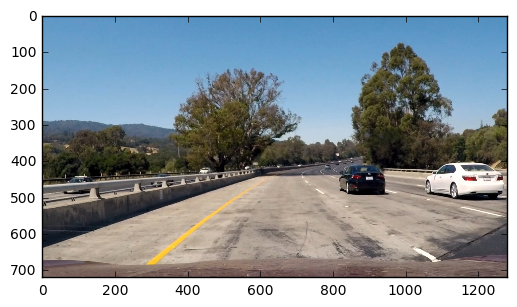

In [904]:
image = mpimg.imread('test_images/test1.jpg')
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# create blank map
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# add color to heatmap
heatmap = add_heat(heat, hot_windows)

# threshold heat map
final_map = apply_threshold(heatmap, 3)

# create labels
labels = label(final_map)

# draw boxes around labels
draw_img = draw_labeled_bboxes(np.copy(image), labels)

# show image
# plt.imshow(heatmap, cmap='hot')
# plt.imshow(draw_img)

# Section 3: Apply pipeline to video

In [905]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from PIL import Image


In [906]:
color_space = 'YCrCb'# Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 4 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32 # 16 # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [907]:
region_window = [[(680,400), (260,260)],
                [(600,400), (220, 220)],
                [(560,400), (166, 166)],
                [(540,400), (132,132)],
                [(520,400), (114,114)],
                [(500,400), (90,90)],
                [(480,400), (78,78)],
                [(470,400), (56,56)],
                [(460,400), (40,40)]]

#[(450,400), (30,30)],
#[(440,400), (20,20)]]

In [980]:
class Car:

    def __init__(self):
        self.centroids = []
        self.widths = []
        self.heights = []
        self.nframes = 0 
        self.nfound = 0
        self.memory_size = 100
        self.retired = False
        
    def add_data(self, height, width, centroid):
        if len(self.centroids) >= self.memory_size:
            self.heights.pop(0)
            self.widths.pop(0)
            self.centroids.pop(0)
        self.heights.append(height)
        self.widths.append(width)
        self.centroids.append(centroid)
        self.nfound+=1
        
    def valid(self):
        return self.nfound >= 5 and not self.retired
    
    def bounding_box(self):
        c = self.average_centroid()
        w = self.average_width()
        h = self.average_height()
        return (int(c[0]-w/2), int(c[1]-h/2)), (int(c[0]+w/2), int(c[1]+h/2))
    
    def average_centroid(self):
        weights = range(1,11,1)
        return np.ma.average(self.centroids[-10:], weights=weights[:len(self.centroids)], axis=0)  

    def average_height(self):
        weights = range(1,11,1)
        return np.ma.average(self.heights[-10:], weights=weights[:len(self.heights)], axis=0)  

    def average_width(self):
        weights = range(1,11,1)
        return np.ma.average(self.widths[-10:], weights=weights[:len(self.widths)], axis=0)  
    
    def is_similar(self, cnew):
        c = self.average_centroid()
        w = self.average_width()
        h = self.average_height()

        # estimate average centroid based on last positions
        distance = np.linalg.norm(np.array(c)-np.array(cnew))
        margin = 30
        
        # check centroids distance
        # check if one box is contained in another
        if distance < margin or \
            ((cnew[0] >= int(c[0]-w/2) and cnew[0] <= int(c[0]+w/2)) and \
            (cnew[1] >= int(c[1]-h/2) and cnew[1] <= int(c[1]+h/2))):
            return True
        
        return False
        

In [981]:
def pipeline(image, debug=False,  threshold=10, xy_overlap=(0.75, 0.75)):
    
    draw_image = np.copy(image)

    all_windows = []
    for region, window, in region_window:
    
        # Adjust these parameters
        y_start_stop = [region[1], region[0]]
        x_start_stop = [500, 1280]
        xy_window = window
        
        # get windows
        windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                            xy_window=xy_window, xy_overlap=xy_overlap)
        
        all_windows.extend(windows)
     
    # convert to 0-1 range for classification
    image = image.astype(np.float32)/255

    # search for windows with possible predictions
    hot_windows = search_windows(image, all_windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    # create blank map
    heatmap_blank = np.zeros_like(image[:,:,0]).astype(np.float)

    # add color to heatmap
    heatmap_full = add_heat(heatmap_blank, hot_windows)

    # add to class and calculate moving average
    #hm.add_heatmap(heatmap_full)
    #heatmap_avg = hm.get_moving_heatmap()

    # threshold heat map
    heatmap_thresh = apply_threshold(heatmap_full, threshold)    

    # create labels
    labels = label(heatmap_thresh)
    
    for car_number in range(1, labels[1]+1):
    
        # isolate points for that 
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # calculate measures for car
        height = np.max(nonzeroy) - np.min(nonzeroy)
        width = np.max(nonzerox) - np.min(nonzerox)
        centroid = (width/2.0 + np.min(nonzerox), height/2.0 + np.min(nonzeroy))
        
        valid = True
        # check if window size makes sense
        for idx in range(len(region_window)):
            limit_y = region_window[idx][0][0]
            if idx == (len(region_window)-1):
                base_y = 400
            else:
                base_y = region_window[idx+1][0][0]
            # if it is within the range of the region
            if centroid[1] <= limit_y and centroid[1] > base_y:
                # check if height and width are as expected
                if not width > (region_window[idx][1][0]/2.) or \
                    not height > (region_window[idx][1][1]/2.) :
                    valid = False 
            
        # check if there is car with similar measures existing
        if valid:
            new = True
            for car in cars:
                # only proceed if car not retired
                if not car.retired:
                    if car.is_similar(centroid):
                        # if car similar, add data to existing car
                        car.add_data(height, width, centroid)
                        new = False
                        break

            # if no cars appears to be new, create a new one
            if new:
                new_car = Car()
                new_car.add_data(height, width, centroid)
                cars.append(new_car)
            
    # Iterate through all existing cars
    for car in cars:
        # add one frame to count
        car.nframes+=1
        # if found less than frames, kill car
        if car.nframes > (car.nfound+3):
            # retire car
            car.retired = True
        # it will not show until each car has at least X centroids
        if car.valid():
            bbox = car.bounding_box()
            cv2.rectangle(draw_image, bbox[0], bbox[1], (0,0,255), 6)
    
    # draw boxes around labels
    # draw_image = draw_labeled_bboxes(draw_image, labels)

    if debug:
        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
        return window_img, draw_image
    
    # return labels
    return draw_image

### Test on test images

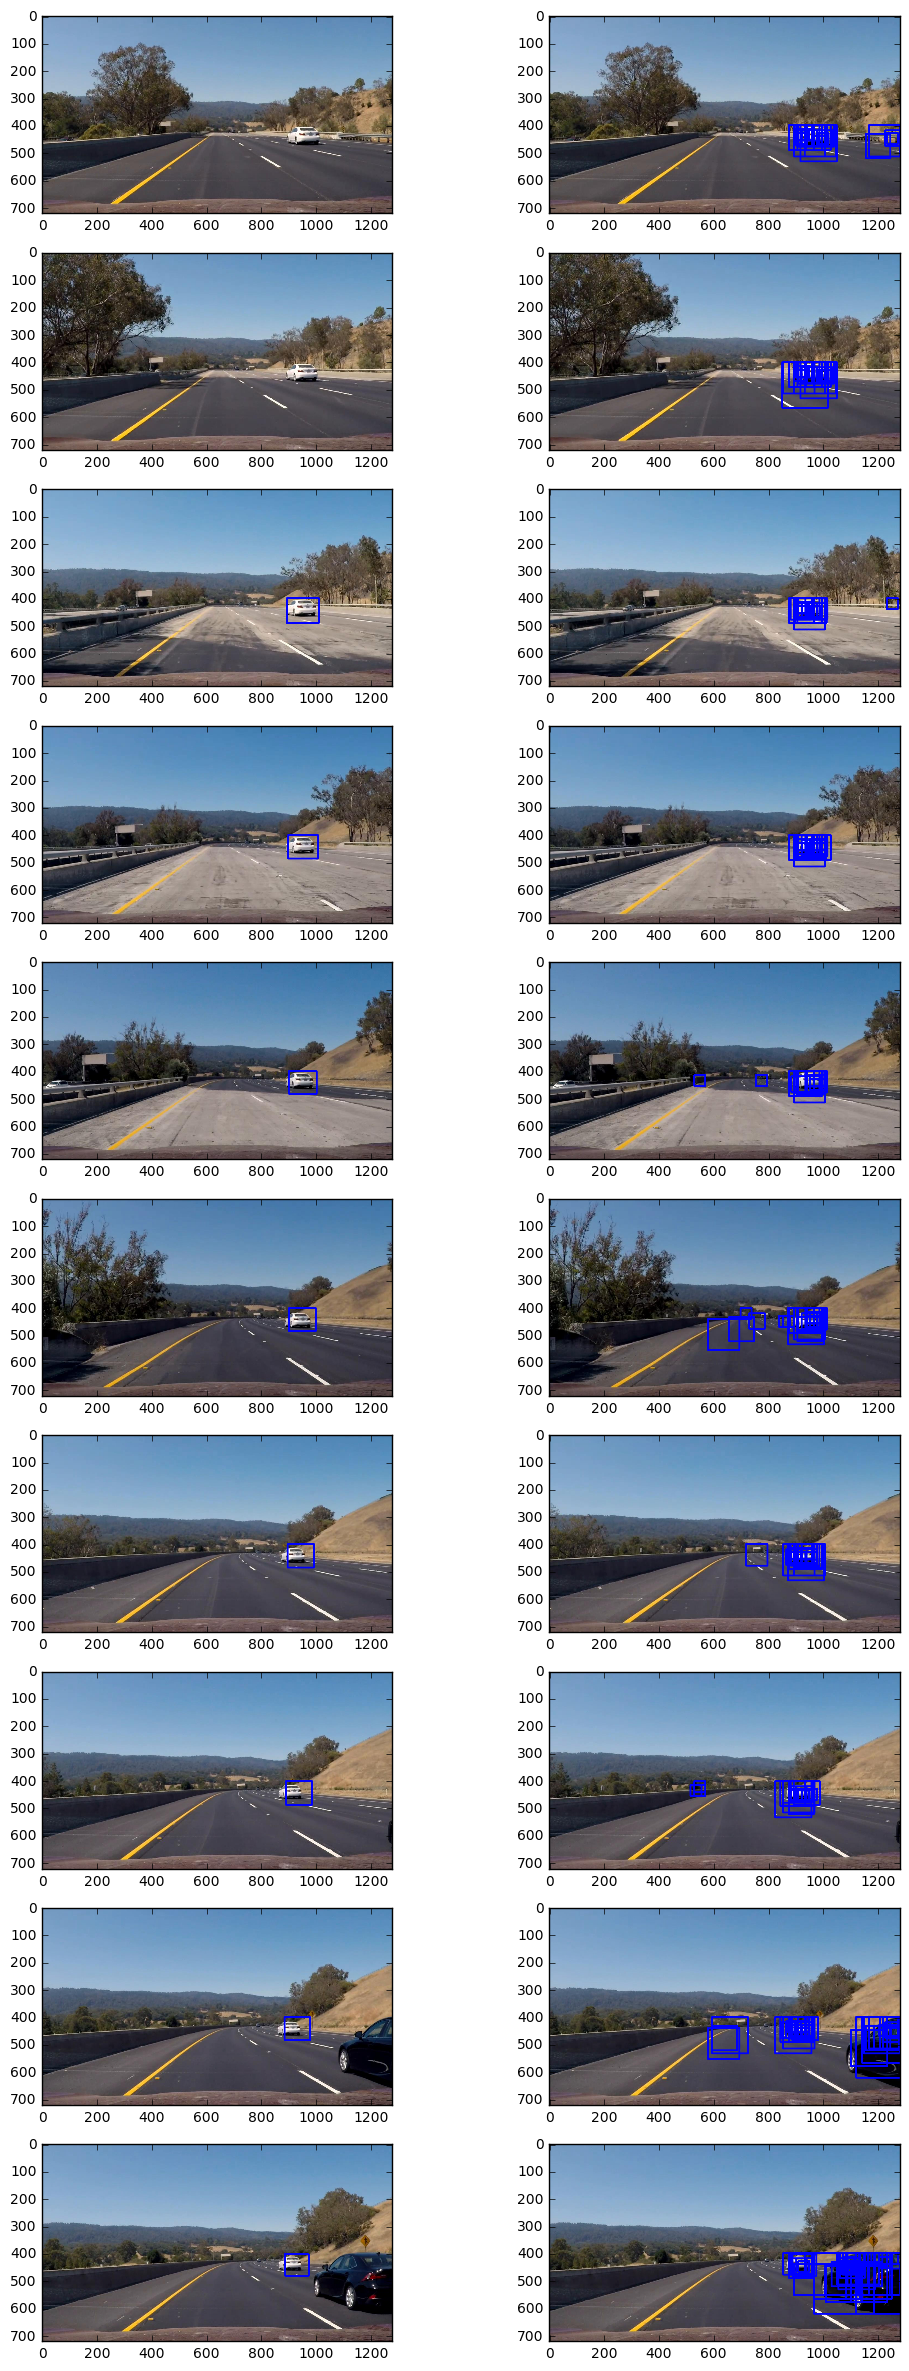

In [917]:
# using videopipeline, so it will not show for a few frames

cars=[]
test_images = glob.glob('test_images2/frame2*.jpg')[1:11]
n = len(test_images)
plt.figure(figsize=(12,n*3))
grid = gs.GridSpec(n,2)

for idx, img_file in enumerate(test_images):
    img = mpimg.imread(img_file)
    wm, dimg = pipeline(img,debug=True, threshold=4, xy_overlap=(0.65, 0.65))
    # plot image
    ax = plt.subplot(grid[idx*2])
    ax.imshow(dimg)
    # plot transformed image
    ax = plt.subplot(grid[(idx*2)+1])
    ax.imshow(wm)

### Test on video

In [982]:
#create lanes
cars=[]
regular_output = 'sample_output.mp4'
clip1 = VideoFileClip("sample_video.mp4")
regular_clip = clip1.fl_image(pipeline) 

%time regular_clip.write_videofile(regular_output, audio=False);

[MoviePy] >>>> Building video sample_output.mp4
[MoviePy] Writing video sample_output.mp4


 99%|█████████▉| 107/108 [02:30<00:01,  1.42s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: sample_output.mp4 

CPU times: user 2min 29s, sys: 808 ms, total: 2min 30s
Wall time: 2min 31s


In [983]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(regular_output))

# Identifying lane lines

In [926]:
def get_perspective_tranform(mtx, dist, nx=9, ny=6, offset=300, img_file='test_images/straight_lines1.jpg'):
    """ Calculate source and destination to be used for warping image"""

    # preprocess image
    sample_img = mpimg.imread(img_file)
    undist_img = cv2.undistort(sample_img, mtx, dist, None, mtx)

    # define source
    # src = np.array([[609, 440],[668, 440],[1030,675],[276,675]], dtype=np.float32)
    #src = np.array([[594, 450],[686, 450],[1085,700],[220,700]], dtype=np.float32)
    #src = np.array([[610, 440],[669, 440],[1090,700],[218,700]], dtype=np.float32)
    src = np.array([[610, 440],[667, 440],[1050,675],[260,675]], dtype=np.float32)
    
    # calculate destination
    h,w = undist_img.shape[:2]
    dst = np.array([[offset,0],[w-offset,0],
                    [w-offset, h],[offset, h]], 
                   dtype=np.float32)

    # get matrix M
    M = cv2.getPerspectiveTransform(src,dst)

    return M

In [930]:
from support_func import *

ret, mtx, dist, rvecs, tvecs = calibrate_camera()
M = get_perspective_tranform(mtx, dist)
Minv = np.linalg.inv(M)
sample_img= mpimg.imread('test_images/straight_lines1.jpg')

In [931]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, img_shape):
        self.fits = []
        self.memory_size = 5
        self.count_trues = 0
        self.count_falses = 0 

        
    def add_fit(self, new_fit):
        if len(self.fits) >= self.memory_size:
            self.fits.pop(0)
        self.fits.append(new_fit)
        

    def get_best_fit(self):
        """ Use a moving average to determine best fit
        Uses past 5 results as input, if available """

        weights=range(1,self.memory_size+1)
        return np.ma.average(self.fits, weights=weights[:len(self.fits)], axis=0)  


In [932]:
def process_image(image, debug=False):
    
    ## Undistort image, based on previous camera calibration
    undist_img = cv2.undistort(image, mtx, dist, None, mtx)

    # warp image    
    warped_img = cv2.warpPerspective(undist_img, M, (image.shape[1],image.shape[0]), 
                                    flags=cv2.INTER_LINEAR)
    
    
    ## Preprocesss
    combined = preprocess(warped_img)

    lefty, leftx, righty, rightx = get_lane_points_first_frame(combined)

    # fitting a second order polynomial 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    lvalid = True
    rvalid = True
    
    # base points
    if leftx[0] < 200 or leftx[0] > 450:
        lvalid = False
    if rightx[0] < 900 or rightx[0] > 1100:
        rvalid = False
    
    # curvature
    curvature_left = measure_curvature(lefty, leftx, left_fit)
    curvature_right = measure_curvature(righty, rightx, right_fit)
    if curvature_left >= curvature_right:
        cratio = curvature_left/curvature_right
    else:
        cratio = curvature_right/curvature_left
    if cratio > 2.0:
        lvalid = False
        rvalid = False
        
    # measure base distance and top distance
    xm_per_pix = 3.7/700
    base_distance = abs(leftx[0] - rightx[0])*xm_per_pix
    top_distance = abs(leftx[-1] - rightx[-1])*xm_per_pix
    if (base_distance < 3.30 or base_distance > 3.90) or \
        (top_distance < 2.00 or top_distance > 5.00):
        lvalid = False
        rvalid = False
                    
    # check if left lane is valid
    if not lvalid:
        ll.count_falses += 1
    else:
        ll.count_trues += 1
        ll.add_fit(left_fit)

    # check if right lane is valid
    if not rvalid:
        rl.count_falses += 1
    else:
        rl.count_trues += 1
        rl.add_fit(right_fit)
    
    # change to best fit if in video
    if ll.fits != []:
        left_fit = ll.get_best_fit()
    if rl.fits != []:
        right_fit = rl.get_best_fit()
        
    # extrapolating points
    fity = np.linspace(0, combined.shape[0]-1, combined.shape[0] )
    fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
    fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]       

    # weighted_img = draw_lanes(image, fit_leftx, fit_rightx, fity, Minv)
    if debug:
        weighted_img = debug_lanes(combined, fit_leftx, fit_rightx, fity, left_fit, right_fit, Minv)
    else:
        weighted_img = draw_lanes(image, fit_leftx, fit_rightx, fity, Minv)

    font = cv2.FONT_HERSHEY_SIMPLEX
    
    if debug:
        txt1 = "Ratio of radius of curvature= {:.2f}".format(cratio)
        cv2.putText(weighted_img,txt1,(20,80), font, 2,(255,255,255),2,cv2.LINE_AA)

        txt2 = "Base distance = {:.2f}(m)".format(base_distance)
        cv2.putText(weighted_img,txt2,(20,180), font, 2,(255,255,255),2,cv2.LINE_AA)

        txt3 = "Left-valid: {}".format(str(lvalid))
        cv2.putText(weighted_img,txt3,(20,280), font, 2,(255,255,255),2,cv2.LINE_AA)

        txt4 = "Right-valid: {}".format(str(rvalid))
        cv2.putText(weighted_img,txt4,(20,380), font, 2,(255,255,255),2,cv2.LINE_AA)

    else:
        # average curvature
        avg_curvature = int((curvature_left+curvature_right)/2)
        txt1 = "Radius of curvature = {}(m)".format(avg_curvature)
        
        # output
        cv2.putText(weighted_img,txt1,(20,80), font, 2,(255,255,255),2,cv2.LINE_AA)

        # calculating distance from center
        lane_width = abs(rightx[0] - leftx[0])/2
        lane_center = lane_width + leftx[0]
        image_center = image.shape[1]/2
        distance_from_center = (image_center - lane_center)*xm_per_pix
        
        # output
        if distance_from_center > 0:
            txt2 = "Vehicle is = {:.2f}(m) right of center".format(distance_from_center)
        else:
            txt2 = "Vehicle is = {:.2f}(m) left of center".format(-distance_from_center)
        cv2.putText(weighted_img,txt2,(20,180), font, 2,(255,255,255),2,cv2.LINE_AA)
        
    
    ## Warp lanes drawn back to original image
    return weighted_img


In [933]:
def preprocess(img):
    #color
    color_binary = color_thresh(img, thresh=(150,255))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #gradient
    gradx_binary = abs_sobel_thresh(gray, orient='x', sobel_kernel=5, thresh=(40,100))
    grady_binary = abs_sobel_thresh(gray, orient='y', sobel_kernel=7, thresh=(40,100))
    mag_binary = mag_thresh(gray, sobel_kernel=15, thresh=(20,100))
    dir_binary = dir_thresh(gray, sobel_kernel=15, thresh=(0.70,1.3))

    combined = np.zeros_like(gray)
    combined[((gradx_binary == 1) & (grady_binary == 1)) | ((mag_binary == 1) & (dir_binary==1)) | (color_binary==1)] = 1
    return combined


In [934]:
#create lanes
ll = Line(sample_img.shape[:2])
rl = Line(sample_img.shape[:2])

regular_output = 'sample_output_with_lanes.mp4'
clip1 = VideoFileClip("sample_video.mp4")
regular_clip = clip1.fl_image(process_image) 

%time regular_clip.write_videofile(regular_output, audio=False)

[MoviePy] >>>> Building video sample_output_with_lanes.mp4
[MoviePy] Writing video sample_output_with_lanes.mp4



 99%|█████████▉| 107/108 [00:26<00:00,  4.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: sample_output_with_lanes.mp4 

CPU times: user 28.7 s, sys: 5.21 s, total: 33.9 s
Wall time: 27.3 s


In [935]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(regular_output))

# Combining lane lines and vehicle detection

In [967]:
def pipeline(image, debug=False,  threshold=10, xy_overlap=(0.75, 0.75)):
    
    draw_image = process_image(image)

    all_windows = []
    for region, window, in region_window:
    
        # Adjust these parameters
        y_start_stop = [region[1], region[0]]
        x_start_stop = [500, 1280]
        xy_window = window
        
        # get windows
        windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                            xy_window=xy_window, xy_overlap=xy_overlap)
        
        all_windows.extend(windows)
     
    # convert to 0-1 range for classification
    image = image.astype(np.float32)/255

    # search for windows with possible predictions
    hot_windows = search_windows(image, all_windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    # create blank map
    heatmap_blank = np.zeros_like(image[:,:,0]).astype(np.float)

    # add color to heatmap
    heatmap_full = add_heat(heatmap_blank, hot_windows)

    # add to class and calculate moving average
    #hm.add_heatmap(heatmap_full)
    #heatmap_avg = hm.get_moving_heatmap()

    # threshold heat map
    heatmap_thresh = apply_threshold(heatmap_full, threshold)    

    # create labels
    labels = label(heatmap_thresh)
    
    for car_number in range(1, labels[1]+1):
    
        # isolate points for that 
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # calculate measures for car
        height = np.max(nonzeroy) - np.min(nonzeroy)
        width = np.max(nonzerox) - np.min(nonzerox)
        centroid = (width/2.0 + np.min(nonzerox), height/2.0 + np.min(nonzeroy))
        
        valid = True
        # check if window size makes sense
        for idx in range(len(region_window)):
            limit_y = region_window[idx][0][0]
            if idx == (len(region_window)-1):
                base_y = 400
            else:
                base_y = region_window[idx+1][0][0]
            # if it is within the range of the region
            if centroid[1] <= limit_y and centroid[1] > base_y:
                # check if height and width are as expected
                if not width > (region_window[idx][1][0]/1.5) or \
                    not height > (region_window[idx][1][1]/1.5) :
                    valid = False 
            
        # check if there is car with similar measures existing
        if valid:
            new = True
            for car in cars:
                # only proceed if car not retired
                if not car.retired:
                    if car.is_similar(centroid):
                        # if car similar, add data to existing car
                        car.add_data(height, width, centroid)
                        new = False
                        break

            # if no cars appears to be new, create a new one
            if new:
                new_car = Car()
                new_car.add_data(height, width, centroid)
                cars.append(new_car)
            
    # Iterate through all existing cars
    for car in cars:
        # add one frame to count
        car.nframes+=1
        # if found less than frames, kill car
        if car.nframes > (car.nfound+3):
            # retire car
            car.retired = True
        # it will not show until each car has at least X centroids
        if car.valid():
            bbox = car.bounding_box()
            cv2.rectangle(draw_image, bbox[0], bbox[1], (0,0,255), 6)
    
    # draw boxes around labels
    # draw_image = draw_labeled_bboxes(draw_image, labels)

    if debug:
        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
        return window_img, draw_image
    
    # return labels
    return draw_image

In [968]:
#create lanes
ll = Line(sample_img.shape[:2])
rl = Line(sample_img.shape[:2])
cars=[]

regular_output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
regular_clip = clip1.fl_image(pipeline) 

%time regular_clip.write_videofile(regular_output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [52:06<00:02,  2.49s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 52min 21s, sys: 1min 8s, total: 53min 30s
Wall time: 52min 7s
